In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
from typing import Dict, List, Mapping, Optional

class EmbedderBlock(eqx.Module):
    """
    Embeds input data from daily and irregular time series along with position indices.
    Includes dropout on the embeddings.
    """
    daily_embedder: eqx.nn.Linear
    irregular_embedder: eqx.nn.Linear
    position_embedder: eqx.nn.Embedding
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(self, 
                 daily_in_size: int, 
                 irregular_in_size: int, 
                 max_length: int, 
                 hidden_size: int,
                 dropout_rate: float, 
                 key: jax.random.PRNGKey):
        
        self.daily_embedder = eqx.nn.Linear(in_features=daily_in_size, out_features=hidden_size, key=key)
        self.irregular_embedder = eqx.nn.Linear(in_features=irregular_in_size, out_features=hidden_size, key=key)
        self.position_embedder = eqx.nn.Embedding(num_embeddings=max_length, embedding_size=hidden_size, key=key)
        self.layernorm = eqx.nn.LayerNorm(shape=(hidden_size,))
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(self, 
                 daily_data: jnp.ndarray, 
                 irregular_data: jnp.ndarray, 
                 position_ids: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:
        
        daily_embeds = jax.vmap(self.daily_embedder)(daily_data)
        irregular_embeds = jax.vmap(self.irregular_embedder)(irregular_data)
        position_embeds = jax.vmap(self.position_embedder)(position_ids)
        embedded_inputs = daily_embeds + irregular_embeds + position_embeds
        embedded_inputs = self.dropout(embedded_inputs, key=key)
        embedded_inputs = jax.vmap(self.layernorm)(embedded_inputs)
        return embedded_inputs


class AttentionBlock(eqx.Module):
    """
    Implements a multi-head self-attention mechanism, integrating static data into the attention process.
    Includes dropout in the output of the attention.
    """
    attention: eqx.nn.MultiheadAttention
    layernorm: eqx.nn.LayerNorm
    static_linear: eqx.nn.Linear
    dropout: eqx.nn.Dropout

    def __init__(self, 
                 hidden_size: int, 
                 num_heads: int, 
                 static_in_size: int,
                 dropout_rate: float,
                 key: jax.random.PRNGKey):
        
        keys = jax.random.split(key)
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads, 
            query_size=hidden_size, 
            key_size=hidden_size, 
            value_size=hidden_size, 
            output_size=hidden_size, 
            key=keys[0])
        self.layernorm = eqx.nn.LayerNorm(shape=(hidden_size,))
        self.static_linear = eqx.nn.Linear(in_features=static_in_size, out_features=hidden_size, key=keys[1])
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(self, 
                 inputs: jnp.ndarray, 
                 static_data: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:

        static_embedding = self.static_linear(static_data)
        static_embedding = jnp.expand_dims(static_embedding, axis=0)
        modified_keys = inputs + static_embedding
        modified_values = inputs + static_embedding
        
        attention_output = self.attention(inputs, modified_keys, modified_values)
        attention_output = self.dropout(attention_output, key=key)
        result = attention_output + inputs
        result = jax.vmap(self.layernorm)(result)
        return result

class FeedForwardBlock(eqx.Module):
    """
    Applies a two-layer feed-forward network with GELU activation in between. Includes dropout after the MLP layer.
    """
    mlp: eqx.nn.Linear
    output: eqx.nn.Linear
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(self, 
                 hidden_size: int, 
                 intermediate_size: int,
                 dropout_rate: float,
                 key: jax.random.PRNGKey):
        
        keys = jax.random.split(key)
        self.mlp = eqx.nn.Linear(in_features=hidden_size, out_features=intermediate_size, key=keys[0])
        self.output = eqx.nn.Linear(in_features=intermediate_size, out_features=hidden_size, key=keys[1])
        self.layernorm = eqx.nn.LayerNorm(shape=(hidden_size,))
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(self,
                 inputs: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:
        
        hidden = self.mlp(inputs)
        hidden = jax.nn.gelu(hidden)
        hidden = self.dropout(hidden, key=key)
        output = self.output(hidden)
        output += inputs
        output = self.layernorm(output) 
        return output

class TransformerLayer(eqx.Module):
    attention_block: AttentionBlock
    ff_block: FeedForwardBlock

    def __init__(self, 
                 hidden_size: int, 
                 intermediate_size: int, 
                 num_heads: int, 
                 static_in_size: int, 
                 dropout_p: float,
                 key: jax.random.PRNGKey):
        
        keys = jax.random.split(key)
        self.attention_block = AttentionBlock(hidden_size, num_heads, static_in_size, dropout_p, keys[0])
        self.ff_block = FeedForwardBlock(hidden_size, intermediate_size, dropout_p, keys[1])

    def __call__(self, 
                 inputs: jnp.ndarray, 
                 static_data: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:

        keys = jax.random.split(key)
        attention_output = self.attention_block(inputs, static_data, keys[0])
        
        ff_keys = jax.random.split(keys[1], attention_output.shape[0])
        output = jax.vmap(self.ff_block)(attention_output, ff_keys)
        return output

class Encoder(eqx.Module):
    embedder_block: EmbedderBlock
    layers: List[TransformerLayer]
    pooler: eqx.nn.Linear

    def __init__(self, 
                 daily_in_size: int, 
                 irregular_in_size: int, 
                 static_in_size: int, 
                 max_length: int, 
                 hidden_size: int, 
                 intermediate_size: int, 
                 num_layers: int, 
                 num_heads: int, 
                 dropout_p: float,
                 key: jax.random.PRNGKey): 
        
        keys = jax.random.split(key, num=3)
        self.embedder_block = EmbedderBlock(daily_in_size, irregular_in_size, max_length, hidden_size, dropout_p, keys[0])
        layer_keys = jax.random.split(keys[1], num=num_layers)
        self.layers = [TransformerLayer(hidden_size, intermediate_size, num_heads, static_in_size, dropout_p, layer_key) for layer_key in layer_keys]
        self.pooler = eqx.nn.Linear(in_features=hidden_size, out_features=hidden_size, key=keys[2])

    def __call__(self, 
                 daily_data: jnp.ndarray, 
                 irregular_data: jnp.ndarray, 
                 position_ids: jnp.ndarray, 
                 static_data: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:

        keys = jax.random.split(key)
        embeddings = self.embedder_block(daily_data, irregular_data, position_ids, keys[0])

        x = embeddings
        layer_keys = jax.random.split(keys[1], len(self.layers))
        for layer, layer_key in zip(self.layers, layer_keys):
            x = layer(x, static_data, layer_key)
        first_token_last_layer = x[..., 0, :]
        pooled = self.pooler(first_token_last_layer)
        pooled = jnp.tanh(pooled)
        return pooled

class EATransformer(eqx.Module):
    encoder: Encoder
    head: eqx.nn.Linear

    def __init__(self, 
                 config: Dict, 
                 key: jax.random.PRNGKey):
        
        keys = jax.random.split(key)
        self.encoder = Encoder(**config, key=keys[0])
        self.head = eqx.nn.Linear(in_features=config["hidden_size"], out_features=1, key=keys[1])

    def __call__(self, 
                 daily_data: jnp.ndarray, 
                 irregular_data: jnp.ndarray, 
                 position_ids: jnp.ndarray, 
                 static_data: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:
        
        pooled_output = self.encoder(daily_data, irregular_data, position_ids, static_data, key)
        return self.head(pooled_output)


In [3]:
import numpy as np

config = {
    "daily_in_size": 1, 
    "irregular_in_size": 6,  
    "static_in_size": 158,          
    "max_length": 365, 
    "hidden_size": 256,
    "intermediate_size": 1024,
    "num_layers": 4,
    "num_heads": 8,
    "dropout_p": 0.4
}

key = jax.random.PRNGKey(5678)
model_key, train_key = jax.random.split(key)
model = EATransformer(config, key=model_key)

params = eqx.filter(model, eqx.is_inexact_array)
leaves = jax.tree_util.tree_leaves(params)
n_params = np.sum([l.size for l in leaves])

def human_readable_size(size_bytes):
    for unit in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size_bytes < 1024:
            return f"{size_bytes:.2f} {unit}"
        size_bytes /= 1024

print(human_readable_size(n_params*4))

13.28 MB


In [4]:
# Configuration
num_samples = 1000
sequence_length = 30
daily_in_size = config["daily_in_size"]
irregular_in_size = config["irregular_in_size"]
static_in_size = config["static_in_size"]
p_missing_data = 0.9

# Generate synthetic data
np.random.seed(42)
daily_data = np.random.rand(num_samples, sequence_length, daily_in_size).astype(np.float32)
irregular_data = np.random.rand(num_samples, sequence_length, irregular_in_size).astype(np.float32)
position_ids = np.tile(np.arange(sequence_length), (num_samples, 1)).astype(np.int32)
static_data = np.random.rand(num_samples, static_in_size).astype(np.float32)
targets = (
    0.5 * np.sum(daily_data, axis=(1, 2)) +
    0.3 * np.sum(irregular_data, axis=(1, 2)) +
    0.2 * np.sum(static_data, axis=1)# +
    # np.random.normal(0, 0.01, num_samples)  # Add some noise
).reshape(num_samples, 1).astype(np.float32)

# Now delete some data from irregular
mask = np.random.rand(*irregular_data.shape[:2]) > p_missing_data   
# Broadcast the mask along the features axis
mask = mask[..., np.newaxis]
irregular_data = irregular_data * mask

# Convert to JAX arrays
daily_data = jnp.array(daily_data)
irregular_data = jnp.array(irregular_data)
position_ids = jnp.array(position_ids)
static_data = jnp.array(static_data)
targets = jnp.array(targets)

print("Hydrology data shape:", daily_data.shape)
print("Satellite data shape:", irregular_data.shape)
print("Position IDs shape:", position_ids.shape)
print("Static data shape:", static_data.shape)
print("Targets shape:", targets.shape)

Hydrology data shape: (1000, 30, 1)
Satellite data shape: (1000, 30, 6)
Position IDs shape: (1000, 30)
Static data shape: (1000, 158)
Targets shape: (1000, 1)


In [5]:
import optax
import tqdm

# Define loss function
def mse_loss(predictions, targets):
    return jnp.mean((predictions - targets) ** 2)

# Define training step
@eqx.filter_value_and_grad
def compute_loss(model, batch_daily, batch_irregular, batch_position, batch_static, batch_targets, batch_keys):
    predictions = jax.vmap(model)(batch_daily, batch_irregular, batch_position, batch_static, batch_keys)
    return mse_loss(predictions, batch_targets)

@eqx.filter_jit
def train_step(model, opt_state, batch_daily, batch_irregular, batch_position, batch_static, batch_targets, batch_keys):
    loss, grads = compute_loss(model, batch_daily, batch_irregular, batch_position, batch_static, batch_targets, batch_keys)
    updates, opt_state = tx.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# Training parameters
batch_size = 9
num_batches = num_samples // batch_size
learning_rate = 1e-3
epochs = 25

# Create an optimizer
tx = optax.adam(learning_rate)
opt_state = tx.init(model)

loss_list = []
for epoch in range(epochs):
    sample_perm = np.random.permutation(num_samples)
    epoch_loss = 0.0

    pbar = tqdm.tqdm(range(num_batches),desc=f"Epoch {epoch+1}")
    for i in pbar:
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size

        batch_ids = sample_perm[batch_start:batch_end]
        
        batch_daily = daily_data[batch_ids]
        batch_irregular = irregular_data[batch_ids]
        batch_position = position_ids[batch_ids]
        batch_static = static_data[batch_ids]
        batch_targets = targets[batch_ids]

        tb_keys = jax.random.split(train_key, batch_size+1)
        train_key = tb_keys[0]
        batch_keys = tb_keys[1:]

        model, opt_state, loss = train_step(model, opt_state, batch_daily, batch_irregular, batch_position, batch_static, batch_targets, batch_keys)
        epoch_loss += loss
        avg_loss = epoch_loss / (i+1)
        pbar.set_postfix_str(f"Loss: {avg_loss:.4f}")
    loss_list.append(avg_loss)


Epoch 10:  19%|███▍              | 21/111 [00:01<00:04, 18.54it/s, Loss: 2.5797]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110a65050>>
Traceback (most recent call last):
  File "/Users/Ted/miniconda3/envs/tss-ml/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Epoch 10:  66%|███████████▊      | 73/111 [00:03<00:02, 18.60it/s, Loss: 2.4576]


KeyboardInterrupt: 

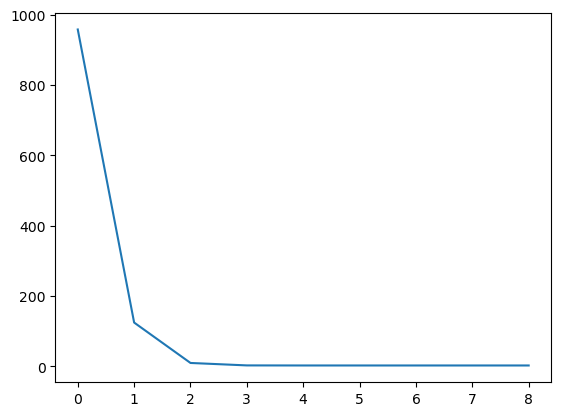

In [6]:
import matplotlib.pyplot as plt

plt.plot(loss_list)